## Install project dependencies

In [1]:
!pip install vaderSentiment
!pip install textstat
!pip install flwr

     |████████████████████████████████| 125 kB 4.3 MB/s 
     |████████████████████████████████| 101 kB 3.1 MB/s 
     |████████████████████████████████| 2.0 MB 27.7 MB/s 
     |████████████████████████████████| 229 kB 4.0 MB/s 


In [88]:
import pandas as pd
import numpy as np
import pickle
import sys
import string
import re
import nltk
import matplotlib.pyplot as plt
import seaborn
import flwr as fl
import os
import time
import warnings
import multiprocessing as mp
from nltk.stem.porter import *
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.feature_selection import SelectFromModel
from sklearn.metrics import classification_report
from sklearn.pipeline import make_pipeline
from sklearn.metrics import confusion_matrix
from sklearn.metrics import log_loss
from sklearn.model_selection import train_test_split
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer as VS
from textstat.textstat import *
from typing import Tuple, Union, List, Dict
from google.colab import drive
%matplotlib inline

## Mounting external storage

In [3]:
drive.mount('/content/drive')

Mounted at /content/drive


## Loading the data

In [4]:
df = pd.read_pickle(open("/content/drive/MyDrive/COMP0029/labeled_data.p", mode='rb'))

In [5]:
df

,count,hate_speech,offensive_language,neither,class,tweet
0,3,0,0,3,2,!!! RT @mayasolovely: As a woman you shouldn't...
1,3,0,3,0,1,!!!!! RT @mleew17: boy dats cold...tyga dwn ba...
2,3,0,3,0,1,!!!!!!! RT @UrKindOfBrand Dawg!!!! RT @80sbaby...
3,3,0,2,1,1,!!!!!!!!! RT @C_G_Anderson: @viva_based she lo...
4,6,0,6,0,1,!!!!!!!!!!!!! RT @ShenikaRoberts: The shit you...
...,...,...,...,...,...,...
25291,3,0,2,1,1,you's a muthaf***in lie &#8220;@LifeAsKing: @2...
25292,3,0,1,2,2,"you've gone and broke the wrong heart baby, an..."
25294,3,0,3,0,1,young buck wanna eat!!.. dat nigguh like I ain...
25295,6,0,6,0,1,youu got wild bitches tellin you lies


In [6]:
df.describe()

,count,hate_speech,offensive_language,neither
count,24783.000000,24783.000000,24783.000000,24783.000000
mean,3.243473,0.280515,2.413711,0.549247
std,0.883060,0.631851,1.399459,1.113299
min,3.000000,0.000000,0.000000,0.000000
25%,3.000000,0.000000,2.000000,0.000000
50%,3.000000,0.000000,3.000000,0.000000
75%,3.000000,0.000000,3.000000,0.000000
max,9.000000,7.000000,9.000000,9.000000


In [7]:
df.columns

Index(['count', 'hate_speech', 'offensive_language', 'neither', 'class',
       'tweet'],
      dtype='object')

### Columns key:
count = number of CrowdFlower users who coded each tweet (min is 3, sometimes more users coded a tweet when judgments were determined to be unreliable by CF).


hate_speech = number of CF users who judged the tweet to be hate speech


offensive_language = number of CF users who judged the tweet to be offensive


neither = number of CF users who judged the tweet to be neither hate speech nor offensive


class = class label determined by majority rule

    0 - hate speech
    1 - offensive  language
    2 - neither

tweet = raw tweet text


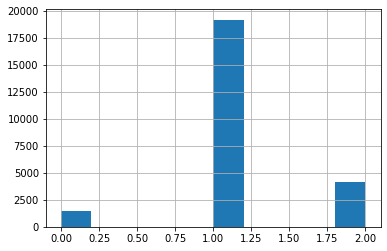

In [8]:
df['class'].hist()

This histogram shows the imbalanced nature of the task - most tweets containing "hate" words as defined by Hatebase were 
only considered to be offensive by the CF coders. More tweets were considered neither hate speech nor offensive than were considered hate speech.

In [9]:
tweets=df.tweet

## Feature generation

In [10]:
nltk.download('stopwords')
stopwords = nltk.corpus.stopwords.words("english")

other_exclusions = ["#ff", "ff", "rt"]
stopwords.extend(other_exclusions)

stemmer = PorterStemmer()


def preprocess(text_string):
    """
    Accepts a text string and replaces:
    1) urls with URLHERE
    2) lots of whitespace with one instance
    3) mentions with MENTIONHERE

    This allows us to get standardized counts of urls and mentions
    Without caring about specific people mentioned
    """
    space_pattern = '\s+'
    giant_url_regex = ('http[s]?://(?:[a-zA-Z]|[0-9]|[$-_@.&+]|'
        '[!*\(\),]|(?:%[0-9a-fA-F][0-9a-fA-F]))+')
    mention_regex = '@[\w\-]+'
    parsed_text = re.sub(space_pattern, ' ', text_string)
    parsed_text = re.sub(giant_url_regex, '', parsed_text)
    parsed_text = re.sub(mention_regex, '', parsed_text)
    return parsed_text

def tokenize(tweet):
    """Removes punctuation & excess whitespace, sets to lowercase,
    and stems tweets. Returns a list of stemmed tokens."""
    tweet = " ".join(re.split("[^a-zA-Z]*", tweet.lower())).strip()
    tokens = [stemmer.stem(t) for t in tweet.split()]
    return tokens

def basic_tokenize(tweet):
    """Same as tokenize but without the stemming"""
    tweet = " ".join(re.split("[^a-zA-Z.,!?]*", tweet.lower())).strip()
    return tweet.split()

vectorizer = TfidfVectorizer(
    tokenizer=tokenize,
    preprocessor=preprocess,
    ngram_range=(1, 3),
    stop_words=stopwords,
    use_idf=True,
    smooth_idf=False,
    norm=None,
    decode_error='replace',
    max_features=10000,
    min_df=5,
    max_df=0.75
    )

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [11]:
#Construct tfidf matrix and get relevant scores
tfidf = vectorizer.fit_transform(tweets).toarray()
vocab = {v:i for i, v in enumerate(vectorizer.get_feature_names_out())}
idf_vals = vectorizer.idf_
idf_dict = {i:idf_vals[i] for i in vocab.values()} #keys are indices; values are IDF scores

/usr/local/lib/python3.7/dist-packages/sklearn/feature_extraction/text.py:401: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['b', 'c', 'e', 'f', 'g', 'h', 'j', 'l', 'n', 'p', 'r', 'u', 'v', 'w'] not in stop_words.
  % sorted(inconsistent)


In [12]:
nltk.download('averaged_perceptron_tagger')
#Get POS tags for tweets and save as a string
tweet_tags = []
for t in tweets:
    tokens = basic_tokenize(preprocess(t))
    tags = nltk.pos_tag(tokens)
    tag_list = [x[1] for x in tags]
    tag_str = " ".join(tag_list)
    tweet_tags.append(tag_str)

[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Unzipping taggers/averaged_perceptron_tagger.zip.


In [13]:
#We can use the TFIDF vectorizer to get a token matrix for the POS tags
pos_vectorizer = TfidfVectorizer(
    tokenizer=None,
    lowercase=False,
    preprocessor=None,
    ngram_range=(1, 3),
    stop_words=None,
    use_idf=False,
    smooth_idf=False,
    norm=None,
    decode_error='replace',
    max_features=5000,
    min_df=5,
    max_df=0.75,
    )

In [14]:
#Construct POS TF matrix and get vocab dict
pos = pos_vectorizer.fit_transform(pd.Series(tweet_tags)).toarray()
pos_vocab = {v:i for i, v in enumerate(pos_vectorizer.get_feature_names_out())}

In [15]:
#Now get other features
sentiment_analyzer = VS()

def count_twitter_objs(text_string):
    """
    Accepts a text string and replaces:
    1) urls with URLHERE
    2) lots of whitespace with one instance
    3) mentions with MENTIONHERE
    4) hashtags with HASHTAGHERE

    This allows us to get standardized counts of urls and mentions
    Without caring about specific people mentioned.
    
    Returns counts of urls, mentions, and hashtags.
    """
    space_pattern = '\s+'
    giant_url_regex = ('http[s]?://(?:[a-zA-Z]|[0-9]|[$-_@.&+]|'
        '[!*\(\),]|(?:%[0-9a-fA-F][0-9a-fA-F]))+')
    mention_regex = '@[\w\-]+'
    hashtag_regex = '#[\w\-]+'
    parsed_text = re.sub(space_pattern, ' ', text_string)
    parsed_text = re.sub(giant_url_regex, 'URLHERE', parsed_text)
    parsed_text = re.sub(mention_regex, 'MENTIONHERE', parsed_text)
    parsed_text = re.sub(hashtag_regex, 'HASHTAGHERE', parsed_text)
    return(parsed_text.count('URLHERE'),parsed_text.count('MENTIONHERE'),parsed_text.count('HASHTAGHERE'))

def other_features(tweet):
    """This function takes a string and returns a list of features.
    These include Sentiment scores, Text and Readability scores,
    as well as Twitter specific features"""
    sentiment = sentiment_analyzer.polarity_scores(tweet)
    
    words = preprocess(tweet) #Get text only
    
    syllables = textstat.syllable_count(words)
    num_chars = sum(len(w) for w in words)
    num_chars_total = len(tweet)
    num_terms = len(tweet.split())
    num_words = len(words.split())
    avg_syl = round(float((syllables+0.001))/float(num_words+0.001),4)
    num_unique_terms = len(set(words.split()))
    
    ###Modified FK grade, where avg words per sentence is just num words/1
    FKRA = round(float(0.39 * float(num_words)/1.0) + float(11.8 * avg_syl) - 15.59,1)
    ##Modified FRE score, where sentence fixed to 1
    FRE = round(206.835 - 1.015*(float(num_words)/1.0) - (84.6*float(avg_syl)),2)
    
    twitter_objs = count_twitter_objs(tweet)
    retweet = 0
    if "rt" in words:
        retweet = 1
    features = [FKRA, FRE,syllables, avg_syl, num_chars, num_chars_total, num_terms, num_words,
                num_unique_terms, sentiment['neg'], sentiment['pos'], sentiment['neu'], sentiment['compound'],
                twitter_objs[2], twitter_objs[1],
                twitter_objs[0], retweet]
    #features = pandas.DataFrame(features)
    return features

def get_feature_array(tweets):
    feats=[]
    for t in tweets:
        feats.append(other_features(t))
    return np.array(feats)

In [16]:
other_features_names = ["FKRA", "FRE","num_syllables", "avg_syl_per_word", "num_chars", "num_chars_total", \
                        "num_terms", "num_words", "num_unique_words", "vader neg","vader pos","vader neu", \
                        "vader compound", "num_hashtags", "num_mentions", "num_urls", "is_retweet"]

In [17]:
feats = get_feature_array(tweets)

In [18]:
#Now join them all up
M = np.concatenate([tfidf,pos,feats],axis=1)

In [19]:
M.shape

(24783, 4023)

In [20]:
#Finally get a list of variable names
variables = ['']*len(vocab)
for k,v in vocab.items():
    variables[v] = k

pos_variables = ['']*len(pos_vocab)
for k,v in pos_vocab.items():
    pos_variables[v] = k

feature_names = variables+pos_variables+other_features_names

# Running the model

In [21]:
X = pd.DataFrame(M)
y = df['class'].astype(int)

In [40]:
feature_transformer = SelectFromModel(LogisticRegression(class_weight='balanced',penalty="l1", C=0.01, solver='liblinear'))

X_ = feature_transformer.fit_transform(X,y)

In [44]:
X_.shape

(24783, 466)

In [65]:
X_train, X_test, y_train, y_test = train_test_split(X_, y, random_state=42, test_size=0.1)

In [66]:
# Changes to hyperparameters to ensure control variables remain constant:
# Solver changed to the new default solver, lbfgs. See comments in start_flower_client for details
# `max_iter` must be changed as lbfgs takes more epochs to successfully converge.
# Framework used for multi class classification is changed to multinomial, as opposed to ovr. 
# This is necessary because of the non-iid data in federated learning scenarios; in a multinomial framework, learning 𝛽𝑖 for a particular class i
# immediately affects our model for other classes j, through the joint model. Consequently, The training algorithm uses log loss aka cross-entropy loss
classifier = LogisticRegression(class_weight='balanced',penalty='l2', C=0.01, max_iter=1500)

In [67]:
model = classifier.fit(X_train, y_train)

In [68]:
y_preds = model.predict(X_test)

Learning the parameters of a prediction function and testing it on the same data is a methodological mistake. 

## Evaluating the results

In [69]:
report = classification_report(y_test, y_preds)

In [70]:
print(report)

              precision    recall  f1-score   support

           0       0.28      0.76      0.41       164
           1       0.97      0.74      0.84      1905
           2       0.58      0.82      0.68       410

    accuracy                           0.75      2479
   macro avg       0.61      0.77      0.64      2479
weighted avg       0.86      0.75      0.78      2479



In [63]:
def plot_confusion_matrix(y, y_preds):
  matrix = confusion_matrix(y,y_preds)
  matrix_proportions = np.zeros((3,3))
  for i in range(0,3):
    matrix_proportions[i,:] = matrix[i,:]/float(matrix[i,:].sum())
  names=['Hate','Offensive','Neither']
  confusion_df = pd.DataFrame(matrix_proportions, index=names,columns=names)
  plt.figure(figsize=(5,5))
  seaborn.heatmap(confusion_df,annot=True,annot_kws={"size": 12},cmap='gist_gray_r',cbar=False, square=True,fmt='.2f')
  plt.ylabel(r'True categories',fontsize=14)
  plt.xlabel(r'Predicted categories',fontsize=14)
  plt.tick_params(labelsize=12)

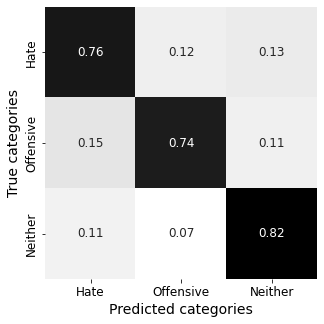

In [86]:
plot_confusion_matrix(y_test,y_preds)

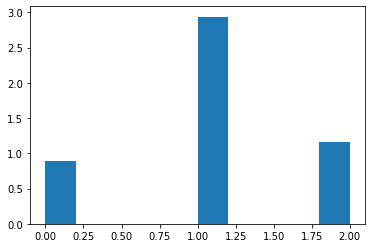

In [92]:
# Distribution of estimates
# The density parameter, which normalizes bin heights so that the integral of the histogram is 1. 
# The resulting histogram is an approximation of the probability density function.
plt.hist(y_preds, density=True)
plt.show()

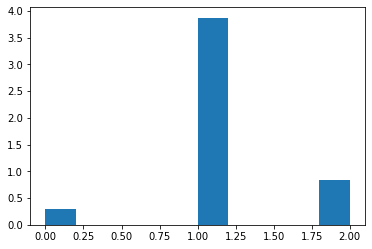

In [93]:
# True distribution
plt.hist(y, density=True)
plt.show()

# Federating The Model

Single-machine simulation of a federated learning system using Flower

## Utility Functions

In [94]:
XY = Tuple[np.ndarray, np.ndarray]
Dataset = Tuple[XY, XY]
LogRegParams = Union[XY, Tuple[np.ndarray]]
XYList = List[XY]


def get_model_parameters(model: LogisticRegression) -> LogRegParams:
#Returns the paramters of a sklearn LogisticRegression model.
    if model.fit_intercept:
        params = (model.coef_, model.intercept_)
    else:
        params = (model.coef_,)
    return params


def set_model_params(
    model: LogisticRegression, params: LogRegParams
) -> LogisticRegression:
#Sets the parameters of a sklean LogisticRegression model.
    model.coef_ = params[0]
    if model.fit_intercept:
        model.intercept_ = params[1]
    return model


def set_initial_params(model: LogisticRegression):
#Sets initial parameters as zeros Required since model params are
#uninitialized until model.fit is called.
#But server asks for initial parameters from clients at launch. Refer
#to sklearn.linear_model.LogisticRegression documentation for more
#information.

    n_classes = 3  # our dataset has 3 classes
    n_features = 466  # Number of features in dataset after feature selection by transformer
    model.classes_ = np.array([i for i in range(n_classes)])

    model.coef_ = np.zeros((n_classes, n_features))
    if model.fit_intercept:
        model.intercept_ = np.zeros((n_classes,))

def load_dataset() -> Dataset:
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1)
    return (X_train, y_train), (X_test, y_test)

def partition(X: np.ndarray, y: np.ndarray, num_partitions: int) -> XYList:
# Split X and y into a number of partitions.
    return list(
        zip(np.array_split(X, num_partitions), np.array_split(y, num_partitions))
    )

## Server API

In [34]:
def fit_round(rnd: int) -> Dict:
    """Send round number to client."""
    return {"rnd": rnd}


def get_eval_fn(model: LogisticRegression):
    """Return an evaluation function for server-side evaluation."""

    # Load test data here to avoid the overhead of doing it in `evaluate` itself
    _, (X_test, y_test) = load_dataset()

    # Select features
    X_test_ = feature_transformer.transform(X_test)

    # The `evaluate` function will be called after every round
    def evaluate(parameters: fl.common.Weights):
        # Update model with the latest parameters
        set_model_params(model, parameters)
        # Calculate cross-entropy loss
        loss = log_loss(y_test, model.predict_proba(X_test_))
        accuracy = model.score(X_test_, y_test)
        return loss, {"accuracy": accuracy}

    return evaluate

In [35]:
def start_flower_server():
  print('function: start_flower_server')
  print('module name:', __name__)
  print('parent process:', os.getppid())
  print('process id:', os.getpid())

  model = LogisticRegression()
  set_initial_params(model)
  strategy = fl.server.strategy.FedAvg(
        min_available_clients=2,
        eval_fn=get_eval_fn(model),
        on_fit_config_fn=fit_round,
  )
  fl.server.start_server("0.0.0.0:80", strategy=strategy, config={"num_rounds": 5})

## Client API

In [100]:
def start_flower_client(X_train_: np.ndarray, y_train: np.ndarray, X_test_: np.ndarray, y_test: np.ndarray):
  print('function: start_flower_client')
  print('module name:', __name__)
  print('parent process:', os.getppid())
  print('process id:', os.getpid())

  # Create LogisticRegression Model
  # max_iter: way to limit the number of epochs. One epoch means that each sample in the training dataset has had an opportunity 
  # to update the internal model parameters. The solver iterates until convergence (determined by ‘tol’) or this number of iterations.
  # i.e., the learning will be stopped either when the solver iterates max_iter times or when the cost between two iterations changes less than tol, 
  # whichever comes first. From sklearn.linear_model.LogisticRegression documentation we can see that ‘tol’ is 1e-4 (0.0001) by default.
  # warm_start: prevent refreshing weights when fitting, this is required for federated learning
  # As a result of the fact that warm_start is required, the variable solver must be changed because liblinear does not support warm start
  # multi_class is set to ovr because the default value for multi_class is 'multinomial' for all solvers other than liblinear.
  # The centralized model uses ovr framework so this is one of our control variables
  #
  model = LogisticRegression(penalty='l2', max_iter=1, warm_start=True, class_weight='balanced', C=0.01)

  # Setting initial parameters, akin to model.compile for keras models
  set_initial_params(model)

  # Define Flower client
  class MnistClient(fl.client.NumPyClient):
    def get_parameters(self): # type: ignore
      return get_model_parameters(model)

    def fit(self, parameters, config):
      set_model_params(model, parameters)
      # Ignore convergence failure due to low local epochs
      with warnings.catch_warnings():
          warnings.simplefilter("ignore")
          model.fit(X_train_, y_train)
      print(f"Training finished for round {config['rnd']}")
      return get_model_parameters(model), len(X_train_), {}

    def evaluate(self, parameters, config):
      set_model_params(model, parameters)
      loss = log_loss(y_test, model.predict_proba(X_test_))
      accuracy = model.score(X_test_, y_test)
      return loss, len(X_test_), {"accuracy": accuracy}

  # Start Flower client
  fl.client.start_numpy_client("0.0.0.0:80", client=MnistClient())

In [98]:
def start_flower_clients(number_of_clients):
  # Load dataset
  (X_train, y_train), (X_test, y_test) = load_dataset()

  # Select features
  X_train_ = feature_transformer.transform(X_train)
  X_test_ = feature_transformer.transform(X_test)

  # Split train set into number_of_clients partitions.
  partitioned_train_set = partition(X_train_, y_train, number_of_clients)

  for i in range(number_of_clients):
    (X_train_partition, y_train_partition) = partitioned_train_set[i]
    client_process = mp.Process(target=start_flower_client, args=(X_train_partition, y_train_partition, X_test_, y_test))
    client_process.start()
    processes.append(client_process)

## Driver Code

In [101]:
# This will hold all the processes which we are going to create
processes = []

# Start Flower server
server_process = mp.Process(target=start_flower_server)
server_process.start()
processes.append(server_process)

# Optionally block the script here for a second or two so the server has time to start
time.sleep(2)

# Start Flower clients
start_flower_clients(2)

# Wait for processes to finish
for p in processes:
  p.join()

function: start_flower_server
module name: __main__
parent process: 62
process id: 2280


INFO flower 2022-01-13 14:52:59,795 | app.py:80 | Flower server running (insecure, 5 rounds)
INFO flower 2022-01-13 14:52:59,798 | server.py:118 | Initializing global parameters
INFO flower 2022-01-13 14:52:59,800 | server.py:304 | Requesting initial parameters from one random client


function: start_flower_client
module name: __main__
parent process: 62
process id: 2299


DEBUG flower 2022-01-13 14:53:01,262 | connection.py:36 | ChannelConnectivity.IDLE
DEBUG flower 2022-01-13 14:53:01,269 | connection.py:36 | ChannelConnectivity.READY
INFO flower 2022-01-13 14:53:01,276 | app.py:61 | Opened (insecure) gRPC connection
INFO flower 2022-01-13 14:53:01,296 | server.py:307 | Received initial parameters from one random client


function: start_flower_client
module name: __main__
parent process: 62
process id: 2317


INFO flower 2022-01-13 14:53:01,305 | server.py:120 | Evaluating initial parameters
INFO flower 2022-01-13 14:53:01,400 | app.py:61 | Opened (insecure) gRPC connection
DEBUG flower 2022-01-13 14:53:01,407 | connection.py:36 | ChannelConnectivity.IDLE
DEBUG flower 2022-01-13 14:53:01,417 | connection.py:36 | ChannelConnectivity.READY
INFO flower 2022-01-13 14:53:01,439 | server.py:127 | initial parameters (loss, other metrics): 1.0986122886681096, {'accuracy': 0.04759983864461476}
INFO flower 2022-01-13 14:53:01,442 | server.py:133 | FL starting
DEBUG flower 2022-01-13 14:53:01,444 | server.py:255 | fit_round: strategy sampled 2 clients (out of 2)


Training finished for round 1
Training finished for round 1


DEBUG flower 2022-01-13 14:53:01,940 | server.py:264 | fit_round received 2 results and 0 failures
INFO flower 2022-01-13 14:53:01,975 | server.py:154 | fit progress: (1, 1.1555754654360695, {'accuracy': 0.40500201694231547}, 0.5308751789998496)
INFO flower 2022-01-13 14:53:01,978 | server.py:199 | evaluate_round: no clients selected, cancel
DEBUG flower 2022-01-13 14:53:01,986 | server.py:255 | fit_round: strategy sampled 2 clients (out of 2)


Training finished for round 2
Training finished for round 2


DEBUG flower 2022-01-13 14:53:02,396 | server.py:264 | fit_round received 2 results and 0 failures
INFO flower 2022-01-13 14:53:02,433 | server.py:154 | fit progress: (2, 1.1555754654360695, {'accuracy': 0.40500201694231547}, 0.989463131998491)
INFO flower 2022-01-13 14:53:02,445 | server.py:199 | evaluate_round: no clients selected, cancel
DEBUG flower 2022-01-13 14:53:02,452 | server.py:255 | fit_round: strategy sampled 2 clients (out of 2)


Training finished for round 3
Training finished for round 3


DEBUG flower 2022-01-13 14:53:02,875 | server.py:264 | fit_round received 2 results and 0 failures
INFO flower 2022-01-13 14:53:02,905 | server.py:154 | fit progress: (3, 1.1555754654360695, {'accuracy': 0.40500201694231547}, 1.4609841419987788)
INFO flower 2022-01-13 14:53:02,912 | server.py:199 | evaluate_round: no clients selected, cancel
DEBUG flower 2022-01-13 14:53:02,919 | server.py:255 | fit_round: strategy sampled 2 clients (out of 2)


Training finished for round 4
Training finished for round 4


DEBUG flower 2022-01-13 14:53:03,295 | server.py:264 | fit_round received 2 results and 0 failures
INFO flower 2022-01-13 14:53:03,351 | server.py:154 | fit progress: (4, 1.1555754654360695, {'accuracy': 0.40500201694231547}, 1.907315167998604)
INFO flower 2022-01-13 14:53:03,359 | server.py:199 | evaluate_round: no clients selected, cancel
DEBUG flower 2022-01-13 14:53:03,366 | server.py:255 | fit_round: strategy sampled 2 clients (out of 2)


Training finished for round 5
Training finished for round 5


DEBUG flower 2022-01-13 14:53:03,734 | server.py:264 | fit_round received 2 results and 0 failures
INFO flower 2022-01-13 14:53:03,790 | server.py:154 | fit progress: (5, 1.1555754654360695, {'accuracy': 0.40500201694231547}, 2.3465218490000552)
INFO flower 2022-01-13 14:53:03,798 | server.py:199 | evaluate_round: no clients selected, cancel
INFO flower 2022-01-13 14:53:03,820 | server.py:172 | FL finished in 2.376279116999285
INFO flower 2022-01-13 14:53:03,828 | app.py:119 | app_fit: losses_distributed []
INFO flower 2022-01-13 14:53:03,835 | app.py:120 | app_fit: metrics_distributed {}
INFO flower 2022-01-13 14:53:03,838 | app.py:121 | app_fit: losses_centralized [(0, 1.0986122886681096), (1, 1.1555754654360695), (2, 1.1555754654360695), (3, 1.1555754654360695), (4, 1.1555754654360695), (5, 1.1555754654360695)]
INFO flower 2022-01-13 14:53:03,841 | app.py:122 | app_fit: metrics_centralized {'accuracy': [(0, 0.04759983864461476), (1, 0.40500201694231547), (2, 0.40500201694231547), (3